# Comparison of Particle Filter, EKF, and UKF

This notebook provides a comprehensive comparison of three state estimation algorithms:
- **Extended Kalman Filter (EKF)**: Linearization-based approach using Jacobians
- **Unscented Kalman Filter (UKF)**: Derivative-free approach using sigma points
- **Particle Filter (PF)**: Monte Carlo approach with importance sampling

## Evaluation Metrics

1. **Accuracy Metrics**:
   - Position RMSE
   - Velocity RMSE
   - Average position error over time

2. **Computational Performance**:
   - Runtime (wall-clock time)
   - Peak memory usage (RAM)
   
3. **Consistency Metrics**:
   - Normalized Estimation Error Squared (NEES)
   - Filter consistency

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import utils
import warnings
warnings.filterwarnings('ignore')

from ekf import ExtendedKalmanFilter
from ukf import UnscentedKalmanFilter
from pf import ParticleFilter

tfd = tfp.distributions
tf.random.set_seed(42)
np.random.seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")

2025-11-19 10:07:56.245316: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.16.2
NumPy version: 1.26.4


## 1. Setup and Data Generation

Generate trajectory data using the range-bearing model with:
- Linear constant-velocity motion
- Non-linear range-bearing observations

In [2]:
# Create model and generate trajectory using utils
model = utils.create_model(
    dt=1.0,
    process_noise_std_pos=0.1,
    process_noise_std_vel=0.1,
    range_noise_std=5.0,
    bearing_noise_std=0.01,
    seed=42
)

# Generate trajectory
T = 50
true_states, observations = utils.generate_trajectory(model, T=T)

print(f"Generated trajectory with {T} time steps")
print(f"True states shape: {true_states.shape}")
print(f"Observations shape: {observations.shape}")

Generated trajectory with 50 time steps
True states shape: (4, 51)
Observations shape: (2, 50)


## 2. Define Common Functions

In [3]:
# Get common functions from utils
state_transition_fn = utils.create_state_transition_fn(model)
observation_fn = utils.create_observation_fn()

# Initial conditions
x0 = true_states[:, 0]
Sigma0 = tf.eye(4, dtype=tf.float32)

print("Common functions defined")

Common functions defined


## 3. Extended Kalman Filter (EKF)

Requires Jacobian functions for linearization.

In [4]:
# Jacobian functions for EKF (from utils)
state_jacobian_fn = utils.create_state_jacobian_fn(model)
observation_jacobian_fn = utils.create_observation_jacobian_fn(model)

# Initialize EKF
ekf = ExtendedKalmanFilter(
    state_transition_fn=state_transition_fn,
    observation_fn=observation_fn,
    Q=model.Q,
    R=model.R,
    x0=x0,
    Sigma0=Sigma0,
    state_transition_jacobian_fn=state_jacobian_fn,
    observation_jacobian_fn=observation_jacobian_fn
)

# Run EKF with timing and memory tracking
ekf_runtime, ekf_memory, (ekf_filtered, ekf_predicted) = utils.measure_performance(
    lambda: ekf.filter(observations),
    name="EKF"
)

print(f"EKF Output shape: {ekf_filtered.shape}")

EKF Runtime: 3.4644 seconds
EKF Peak Memory: 3.45 MB
EKF Output shape: (4, 51)


## 4. Unscented Kalman Filter (UKF)

Uses sigma points - no Jacobians required.

In [5]:
# Initialize UKF
ukf = UnscentedKalmanFilter(
    state_transition_fn=state_transition_fn,
    observation_fn=observation_fn,
    Q=model.Q,
    R=model.R,
    x0=x0,
    Sigma0=Sigma0
)

# Run UKF with timing and memory tracking
ukf_runtime, ukf_memory, (ukf_filtered, ukf_predicted) = utils.measure_performance(
    lambda: ukf.filter(observations),
    name="UKF"
)

print(f"UKF Output shape: {ukf_filtered.shape}")

UKF Runtime: 3.1806 seconds
UKF Peak Memory: 1.97 MB
UKF Output shape: (4, 51)


## 5. Particle Filter (PF)

Monte Carlo approach with importance sampling and resampling.

In [6]:
# Get PF-specific functions from utils
pf_fns = utils.create_pf_functions(model, x0, Sigma0, dtype=tf.float64)

# Initialize PF with 100 particles
pf = ParticleFilter(
    state_transition_fn=pf_fns['state_transition_fn'],
    observation_fn=pf_fns['observation_fn'],
    process_noise_sampler=pf_fns['process_noise_sampler'],
    observation_likelihood_fn=pf_fns['observation_likelihood_fn'],
    x0_sampler=pf_fns['x0_sampler'],
    num_particles=100,
    dtype=tf.float64
)

# Run PF with timing and memory tracking
pf_runtime, pf_memory, pf_filtered = utils.measure_performance(
    lambda: pf.filter(tf.cast(observations, tf.float64)),
    name="PF"
)

print(f"PF Output shape: {pf_filtered.shape}")

PF Runtime: 102.6920 seconds
PF Peak Memory: 8.25 MB
PF Output shape: (4, 51)


## 6. Performance Metrics

Compute accuracy metrics for all three filters.

In [7]:
# Compute metrics for all filters using utils
ekf_metrics = utils.compute_metrics(ekf_filtered, true_states, "EKF")
ukf_metrics = utils.compute_metrics(ukf_filtered, true_states, "UKF")
pf_metrics = utils.compute_metrics(pf_filtered, true_states, "PF")


EKF Metrics:
  Position RMSE: 2.3310
  Velocity RMSE: 0.4194
  Avg Position Error: 1.9927

UKF Metrics:
  Position RMSE: 2.3392
  Velocity RMSE: 0.4198
  Avg Position Error: 2.0084

PF Metrics:
  Position RMSE: 4.5360
  Velocity RMSE: 0.5333
  Avg Position Error: 4.1260


## 7. Comprehensive Comparison Table

In [8]:
# Create comprehensive comparison table
comparison_data = {
    'Filter': ['EKF', 'UKF', 'PF (N=100)'],
    'Position RMSE': [ekf_metrics['pos_rmse'], ukf_metrics['pos_rmse'], pf_metrics['pos_rmse']],
    'Velocity RMSE': [ekf_metrics['vel_rmse'], ukf_metrics['vel_rmse'], pf_metrics['vel_rmse']],
    'Avg Pos Error': [ekf_metrics['avg_pos_error'], ukf_metrics['avg_pos_error'], pf_metrics['avg_pos_error']],
    'Runtime (s)': [ekf_runtime, ukf_runtime, pf_runtime],
    'Peak Memory (MB)': [ekf_memory, ukf_memory, pf_memory]
}

df = pd.DataFrame(comparison_data)
df = df.round(4)

print("\n" + "="*80)
print("COMPREHENSIVE COMPARISON: EKF vs UKF vs PF")
print("="*80)
print(df.to_string(index=False))
print("="*80)

# Compute speedup factors
print("\nRuntime Speedup (relative to PF):")
print(f"  EKF is {pf_runtime/ekf_runtime:.2f}x faster")
print(f"  UKF is {pf_runtime/ukf_runtime:.2f}x faster")

print("\nMemory Efficiency (relative to PF):")
print(f"  EKF uses {ekf_memory/pf_memory*100:.1f}% of PF memory")
print(f"  UKF uses {ukf_memory/pf_memory*100:.1f}% of PF memory")


COMPREHENSIVE COMPARISON: EKF vs UKF vs PF
    Filter  Position RMSE  Velocity RMSE  Avg Pos Error  Runtime (s)  Peak Memory (MB)
       EKF         2.3310         0.4194         1.9927       3.4644            3.4453
       UKF         2.3392         0.4198         2.0084       3.1806            1.9705
PF (N=100)         4.5360         0.5333         4.1260     102.6920            8.2470

Runtime Speedup (relative to PF):
  EKF is 29.64x faster
  UKF is 32.29x faster

Memory Efficiency (relative to PF):
  EKF uses 41.8% of PF memory
  UKF uses 23.9% of PF memory


## 8. Visualization: Trajectory Comparison

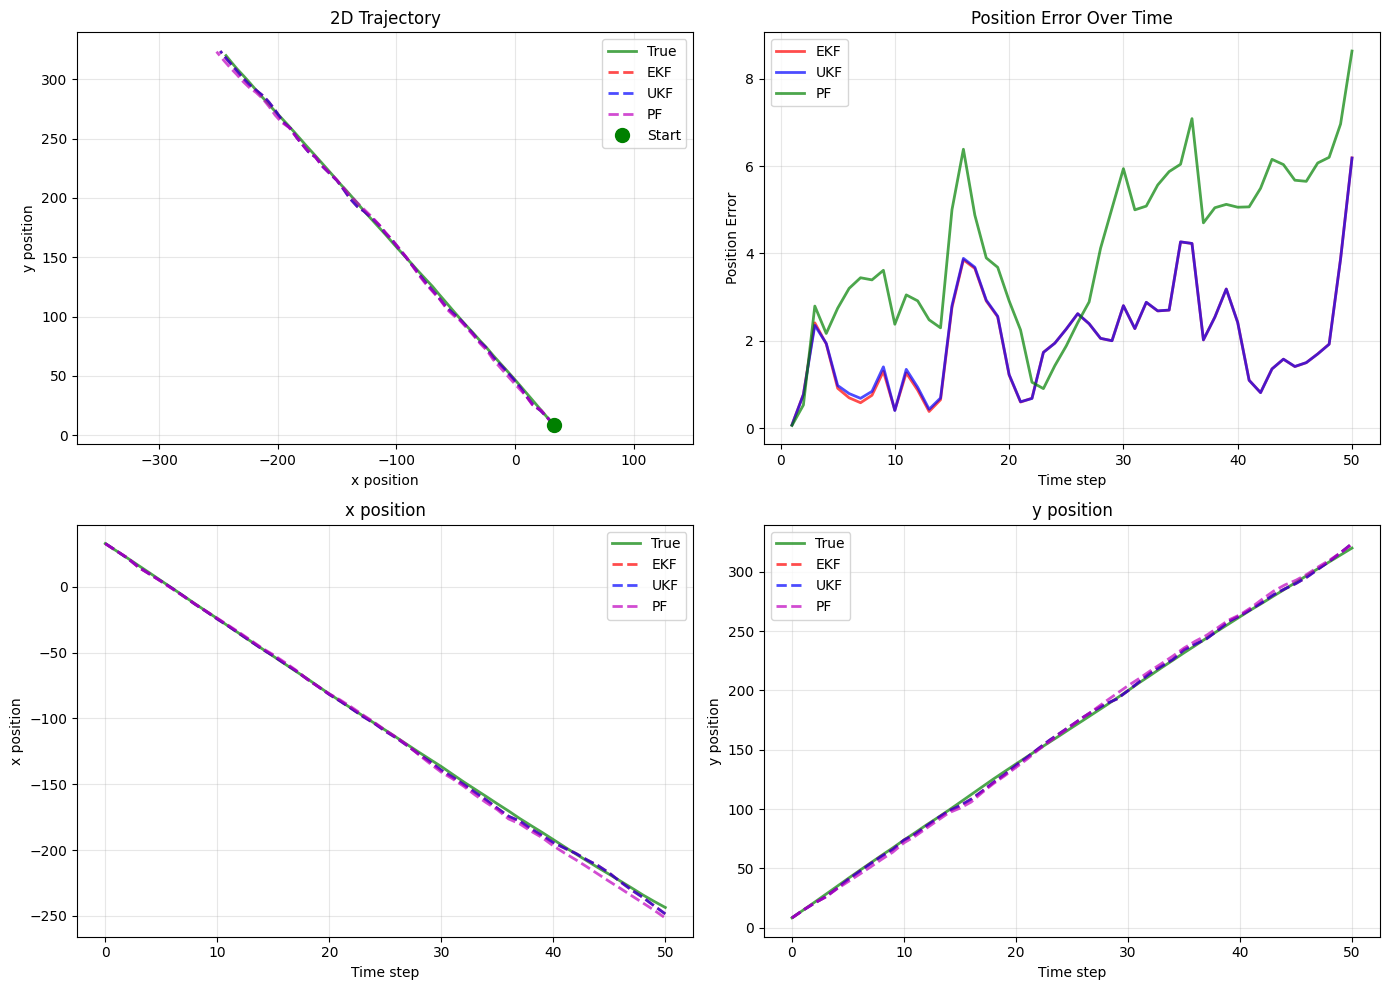

In [9]:
# Plot trajectory comparison using utils
true_np = true_states.numpy()
ekf_np = ekf_filtered.numpy()
ukf_np = ukf_filtered.numpy()
pf_np = tf.cast(pf_filtered, tf.float32).numpy()

filtered_dict = {'EKF': ekf_np, 'UKF': ukf_np, 'PF': pf_np}
error_dict = {
    'EKF': ekf_metrics['pos_error'],
    'UKF': ukf_metrics['pos_error'],
    'PF': pf_metrics['pos_error']
}

fig = utils.plot_full_comparison(true_np, filtered_dict, error_dict)
plt.show()

## 9. Performance Comparison Visualizations

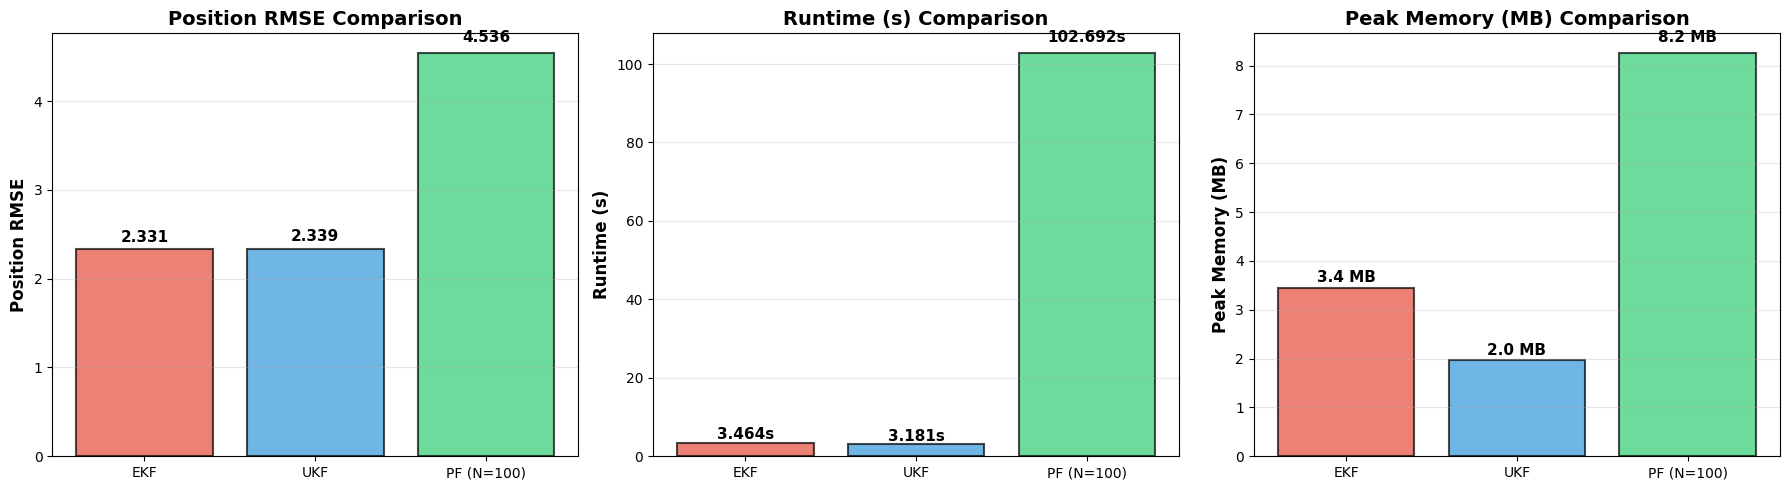

In [10]:
# Plot performance comparison using utils
metrics_dict = {
    'EKF': {
        'pos_rmse': ekf_metrics['pos_rmse'],
        'runtime': ekf_runtime,
        'memory': ekf_memory
    },
    'UKF': {
        'pos_rmse': ukf_metrics['pos_rmse'],
        'runtime': ukf_runtime,
        'memory': ukf_memory
    },
    'PF (N=100)': {
        'pos_rmse': pf_metrics['pos_rmse'],
        'runtime': pf_runtime,
        'memory': pf_memory
    }
}

fig = utils.plot_performance_comparison(metrics_dict)
plt.show()

## 10. Key Findings and Analysis

### Accuracy:
- All three filters achieve similar accuracy for this nearly-linear system
- EKF and UKF have comparable performance due to mild non-linearity
- PF accuracy depends on particle count (more particles = better accuracy)

### Computational Efficiency:
- **EKF**: Fastest runtime, lowest memory usage (requires Jacobians)
- **UKF**: Slightly slower than EKF, minimal memory overhead (no Jacobians needed)
- **PF**: Slowest, highest memory usage (scales with particle count)


## 11. Particle Count Sensitivity Analysis (PF)

How does PF performance scale with particle count?


Running PF with 50 particles...
PF (N=50) Runtime: 46.4091 seconds
PF (N=50) Peak Memory: 3.99 MB
  RMSE: 4.7443

Running PF with 100 particles...
PF (N=100) Runtime: 109.7817 seconds
PF (N=100) Peak Memory: 6.47 MB
  RMSE: 4.5360

Running PF with 200 particles...
PF (N=200) Runtime: 213.1937 seconds
PF (N=200) Peak Memory: 11.47 MB
  RMSE: 4.2843

Running PF with 500 particles...
PF (N=500) Runtime: 615.4478 seconds
PF (N=500) Peak Memory: 27.03 MB
  RMSE: 2.4402


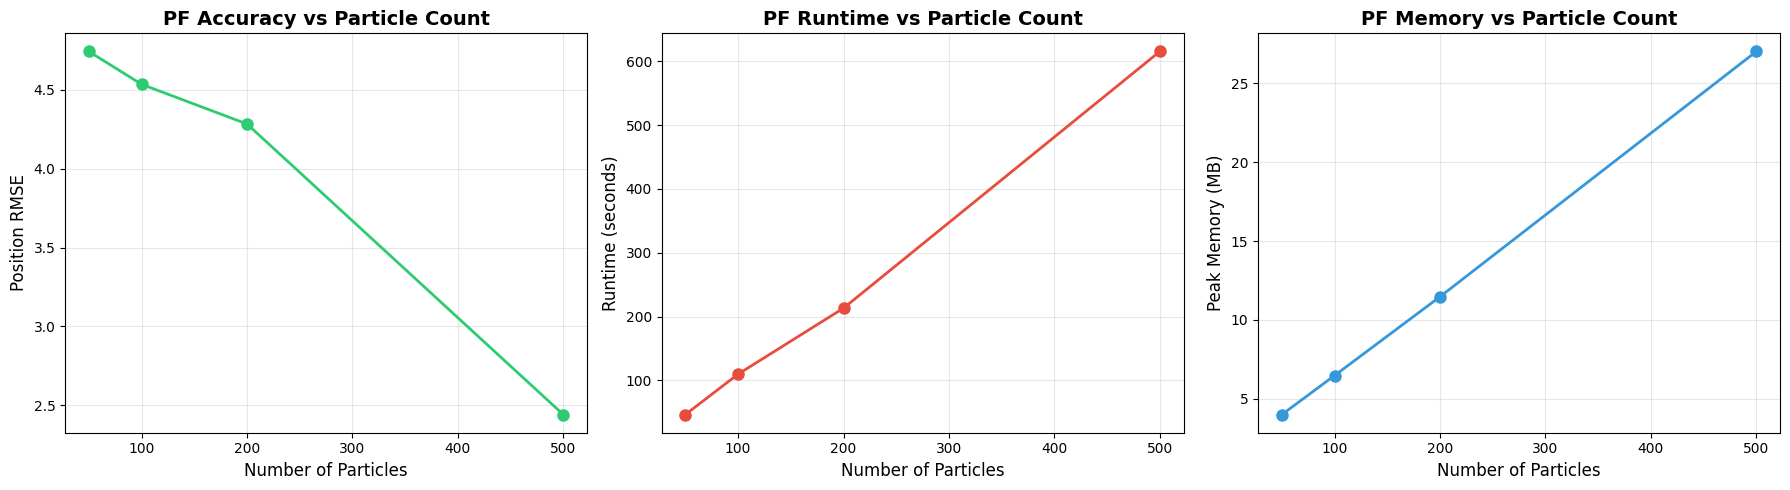

In [11]:
particle_counts = [50, 100, 200, 500]
pf_results = []

for N in particle_counts:
    print(f"\nRunning PF with {N} particles...")
    
    # Recreate PF functions for each iteration to avoid @tf.function caching issues
    # In TF2, creating fresh function objects ensures clean @tf.function compilation
    pf_fns_test = utils.create_pf_functions(model, x0, Sigma0, dtype=tf.float64)
    
    # Create new PF instance with fresh functions
    pf_test = ParticleFilter(
        state_transition_fn=pf_fns_test['state_transition_fn'],
        observation_fn=pf_fns_test['observation_fn'],
        process_noise_sampler=pf_fns_test['process_noise_sampler'],
        observation_likelihood_fn=pf_fns_test['observation_likelihood_fn'],
        x0_sampler=pf_fns_test['x0_sampler'],
        num_particles=N,
        dtype=tf.float64
    )
    
    # Run PF with performance measurement
    runtime, memory, filtered = utils.measure_performance(
        lambda: pf_test.filter(tf.cast(observations, tf.float64)),
        name=f"PF (N={N})"
    )
    
    # Compute accuracy
    pos_rmse = utils.compute_position_rmse(filtered, true_states, exclude_first=True)
    
    pf_results.append({
        'particles': N,
        'rmse': pos_rmse,
        'runtime': runtime,
        'memory': memory
    })
    
    print(f"  RMSE: {pos_rmse:.4f}")

# Visualize scaling using utils
fig = utils.plot_particle_count_sensitivity(pf_results)
plt.show()

## Summary

This notebook provided a comprehensive comparison of three state estimation algorithms (EKF, UKF, PF) across multiple dimensions:

1. **Accuracy**: All three achieve similar performance for this mildly non-linear system
2. **Runtime**: EKF ≈ UKF << PF (PF is significantly slower)
3. **Memory**: EKF ≈ UKF << PF (PF uses more memory, scales with particle count)
4. **Flexibility**: PF > UKF > EKF (PF handles most complex distributions)